In [65]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from scipy.optimize import curve_fit
from scipy.signal import find_peaks, peak_widths

In [66]:
def ViewPulses(filelocation, events, XRange, preTrgrDly):
    with h5py.File(filelocation, 'r') as f:
        for a in range(events):
            pulse = np.array(f['raw_data'][a, :XRange])  # type: ignore
            baseline = np.average(pulse[:preTrgrDly-100])
            pulse = pulse - baseline
            plt.plot(pulse)

def CreateSpectra(filelocation, events, XRange, preTrgrDly, risetime):
    with h5py.File(filelocation, 'r') as f:
        spectra = []
        for a in range(events):
            pulse = np.array(f['raw_data'][a, :XRange])  # type: ignore
            baseline = np.average(pulse[:preTrgrDly-100])
            pulse = pulse - baseline
            sum = np.sum(pulse[preTrgrDly-100:preTrgrDly+risetime-100])
            if sum > 0:
                spectra.append(sum)
        return(spectra)

def Gaussian(x, a, center, sigma, d):
    return a*np.exp(-(x-center)**2/(2*sigma**2))+d

def PeakInfo(hist, d, promF):
    peaklocations, _ = find_peaks(hist, distance=d, prominence=int(np.amax(hist))/promF)
    widths = peak_widths(hist, peaklocations, rel_height=0.5)
    Xranges = []
    coefficients = []
    numberofpeaks = 0
    FWHMs = []
    for i in range(len(peaklocations)):
        try:
            left = int(peaklocations[i]-widths[0][i])
            right = int(peaklocations[i]+widths[0][i])
            x = np.linspace(left, right, right-left)
            popt, pcov = curve_fit(Gaussian, x, hist[left:right], [hist[peaklocations[i]], peaklocations[i], widths[0][i], 0])
            popt[2] = np.abs(popt[2])
            Xranges.append(x)
            coefficients.append(popt)
            numberofpeaks += 1
            FWHMs.append(widths[0][i])
        except:
            pass
    return Xranges, coefficients, numberofpeaks, FWHMs


Specifying that counts start 100 before trigger (preTrgrDly-100)

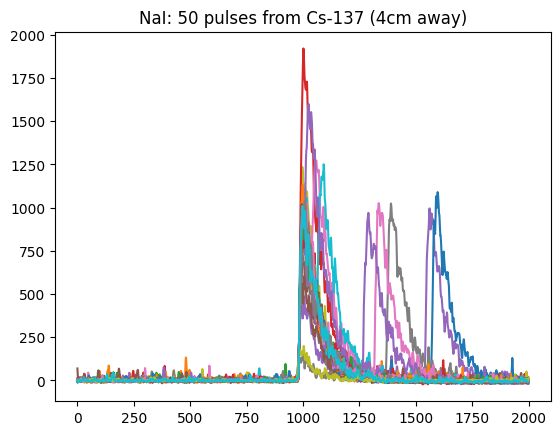

In [67]:
filelocation = r"C:\Users\Operator\Documents\Devin\Code\Data\NaI_Cs137_4cm_30.h5"
events = 50
XRange = 5000
preTrgrDly = 1000
ViewPulses(filelocation, events, XRange, preTrgrDly)
plt.title('NaI: 50 pulses from Cs-137 (4cm away)')
plt.show()

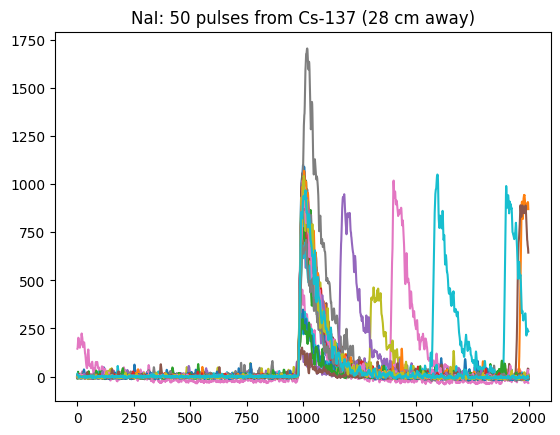

In [68]:
filelocation = r"C:\Users\Operator\Documents\Devin\Code\Data\NaI_Cs137_28cm_30.h5"
events = 50
XRange = 5000
preTrgrDly = 1000
ViewPulses(filelocation, events, XRange, preTrgrDly)
plt.title('NaI: 50 pulses from Cs-137 (28 cm away)')
plt.show()

The initial pulses generally decay mostly away by about 300 counts after the trigger (1.2 microseconds), so I will use 400 as the initial guess for rise time. Don't see much of a difference in pile-up rate between 4 and 28 cm away however. Noting that since the pulse heights seem to average around 1000, integrating over 400 counts would give pulses that are almost all under 400*1000 = 400000. So I will set the histogram range to 0, 400000

1073156.888888889
Centroid is at: 426.6040887283978
FWHM is: 32.0910119513611
% Resolution = 7.522434219281989


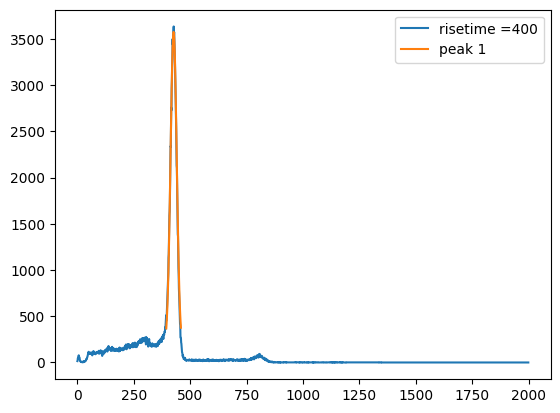

In [69]:
filelocation = r"C:\Users\Operator\Documents\Devin\Code\Data\NaI_Cs137_4cm_30.h5"
events = 200000
XRange = 2000
preTrgrDly = 1000
peakdistance = 10
prominencefactor = 10
risetime = 400
spectra = CreateSpectra(filelocation, events, XRange, preTrgrDly, risetime)
print(np.max(spectra))
hist, bins = np.histogram(spectra, bins = 2000, range = (0, 400000))
plt.plot(range(np.size(hist)), hist, label="risetime =" + str(risetime))
Xranges, coefficients, numberofpeaks, FWHMs = PeakInfo(hist, peakdistance, prominencefactor)
for i in range(numberofpeaks):
    plt.plot(Xranges[i], Gaussian(Xranges[i], *coefficients[i]), label="peak " + str(i+1))
    print("Centroid is at: " + str(coefficients[i][1]))
    print("FWHM is: " + str(2.35*coefficients[i][2]))
    print("% Resolution = " + str(100*2.35*coefficients[i][2]/coefficients[i][1]))
plt.legend(loc='upper right')
plt.show()

Seems like the range can be decreased to half of before. Noting that the maximum of the spectra has a value of 1,110,000. 

Centroid is at: 351.3264517456794
FWHM is: 27.414905894806637
% Resolution = 7.803256987507427
Centroid is at: 430.6490937984748
FWHM is: 34.96574012515384
% Resolution = 8.119311204568865


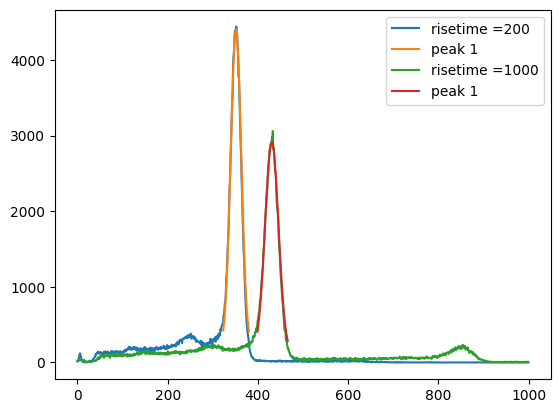

In [70]:
filelocation = r"C:\Users\Operator\Documents\Devin\Code\Data\NaI_Cs137_4cm_30.h5"
risetime = 200

spectra = CreateSpectra(filelocation, events, XRange, preTrgrDly, risetime)
hist, bins = np.histogram(spectra, bins = 1000, range = (0, 200000))
plt.plot(range(np.size(hist)), hist, label="risetime =" + str(risetime))
Xranges, coefficients, numberofpeaks, FWHMs = PeakInfo(hist, peakdistance, prominencefactor)
for i in range(numberofpeaks):
    plt.plot(Xranges[i], Gaussian(Xranges[i], *coefficients[i]), label="peak " + str(i+1))
    print("Centroid is at: " + str(coefficients[i][1]))
    print("FWHM is: " + str(2.35*coefficients[i][2]))
    print("% Resolution = " + str(100*2.35*coefficients[i][2]/coefficients[i][1]))

filelocation = r"C:\Users\Operator\Documents\Devin\Code\Data\NaI_Cs137_4cm_30.h5"
risetime = 1000

spectra = CreateSpectra(filelocation, events, XRange, preTrgrDly, risetime)
hist, bins = np.histogram(spectra, bins = 1000, range = (0, 200000))
plt.plot(range(np.size(hist)), hist, label="risetime =" + str(risetime))
Xranges, coefficients, numberofpeaks, FWHMs = PeakInfo(hist, peakdistance, prominencefactor)
for i in range(numberofpeaks):
    plt.plot(Xranges[i], Gaussian(Xranges[i], *coefficients[i]), label="peak " + str(i+1))
    print("Centroid is at: " + str(coefficients[i][1]))
    print("FWHM is: " + str(2.35*coefficients[i][2]))
    print("% Resolution = " + str(100*2.35*coefficients[i][2]/coefficients[i][1]))

plt.legend(loc='upper right')
plt.show()

The spectra created from a longer rise time will have a photopeak that shows up further to the right on the graph since more of the pulse is integrated over. Setting the integration period to 1000 shows a second peak at twice the magnitude, due to integrating over two pulses. 

With 1000 bins for a range of 200000, equivalent bin size for a full range of values (up to 1110000) would require ~6000 bins.

Centroid is at: 352.6851270559662
FWHM is: 27.643853889158464
% Resolution = 7.83811160961482
Centroid is at: 430.85075178626147
FWHM is: 34.03554011937871
% Resolution = 7.899612563810315


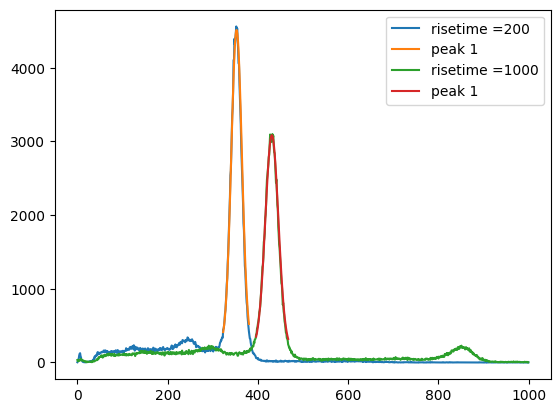

In [71]:
filelocation = r"C:\Users\Operator\Documents\Devin\Code\Data\NaI_Cs137_28cm_30.h5"
risetime = 200

spectra = CreateSpectra(filelocation, events, XRange, preTrgrDly, risetime)
hist, bins = np.histogram(spectra, bins = 1000, range = (0, 200000))
plt.plot(range(np.size(hist)), hist, label="risetime =" + str(risetime))
Xranges, coefficients, numberofpeaks, FWHMs = PeakInfo(hist, peakdistance, prominencefactor)
for i in range(numberofpeaks):
    plt.plot(Xranges[i], Gaussian(Xranges[i], *coefficients[i]), label="peak " + str(i+1))
    print("Centroid is at: " + str(coefficients[i][1]))
    print("FWHM is: " + str(2.35*coefficients[i][2]))
    print("% Resolution = " + str(100*2.35*coefficients[i][2]/coefficients[i][1]))

filelocation = r"C:\Users\Operator\Documents\Devin\Code\Data\NaI_Cs137_28cm_30.h5"
risetime = 1000

spectra = CreateSpectra(filelocation, events, XRange, preTrgrDly, risetime)
hist, bins = np.histogram(spectra, bins = 1000, range = (0, 200000))
plt.plot(range(np.size(hist)), hist, label="risetime =" + str(risetime))
Xranges, coefficients, numberofpeaks, FWHMs = PeakInfo(hist, peakdistance, prominencefactor)
for i in range(numberofpeaks):
    plt.plot(Xranges[i], Gaussian(Xranges[i], *coefficients[i]), label="peak " + str(i+1))
    print("Centroid is at: " + str(coefficients[i][1]))
    print("FWHM is: " + str(2.35*coefficients[i][2]))
    print("% Resolution = " + str(100*2.35*coefficients[i][2]/coefficients[i][1]))

plt.legend(loc='upper right')
plt.show()

Seems like the resolution for the Cs-137 662 keV gamma peak doesn't change drastically between having the source 4 cm away from the detector, and 28 cm away. Going to calculate the resolution for all distances we took data for, integrating over an increasing range of counts: from 100 to 900. Going to use the full range of values for each spectra because of the different ranges over which the pulse is integrated, and using 6000 bins to get about the same range of values per bin as the two plots above.

In [72]:
filelocations = [ 
    r"C:\Users\Operator\Documents\Devin\Code\Data\NaI_Cs137_4cm_30.h5", 
    r"C:\Users\Operator\Documents\Devin\Code\Data\NaI_Cs137_8cm_30.h5", 
    r"C:\Users\Operator\Documents\Devin\Code\Data\NaI_Cs137_12cm_30.h5",
    r"C:\Users\Operator\Documents\Devin\Code\Data\NaI_Cs137_16cm_30.h5",
    r"C:\Users\Operator\Documents\Devin\Code\Data\NaI_Cs137_20cm_30.h5",
    r"C:\Users\Operator\Documents\Devin\Code\Data\NaI_Cs137_24cm_30.h5",
    r"C:\Users\Operator\Documents\Devin\Code\Data\NaI_Cs137_28cm_30.h5",
    ]

filenames = []
data = []
for a in filelocations:
    row = []
    filelocation = a
    filenames.append(os.path.split(a)[1])
    events = 200000
    XRange = 2000
    preTrgrDly = 1000
    peakdistance = 10
    prominencefactor = 10
    for b in range(9):
        resolutions = []
        risetime = 100*(b+2)
        spectra = CreateSpectra(filelocation, events, XRange, preTrgrDly, risetime)
        hist, bins = np.histogram(spectra, bins = 6000)
        Xranges, coefficients, numberofpeaks, FWHMs = PeakInfo(hist, peakdistance, prominencefactor)
        for i in range(numberofpeaks):
            resolutions.append(100*2.35*coefficients[i][2]/coefficients[i][1])
        row.append(np.average(resolutions))    
    data.append(row)

df = pd.DataFrame(data, index=filenames, columns=100*(np.array(range(9))+2))
df.style.background_gradient(axis=None)



,200,300,400,500,600,700,800,900,1000
NaI_Cs137_4cm_30.h5,7.677640,7.600327,7.473598,7.586518,7.630820,7.526991,7.903437,8.042113,8.121040
NaI_Cs137_8cm_30.h5,7.723433,7.613777,7.534948,7.626680,7.596282,7.582887,7.647730,7.798232,8.021329
NaI_Cs137_12cm_30.h5,7.612462,7.424577,7.472181,7.524958,7.598379,7.661004,7.728443,7.810633,7.913164
NaI_Cs137_16cm_30.h5,7.618291,7.592019,7.399259,7.611266,7.568228,7.733580,7.837074,7.927234,8.023442
NaI_Cs137_20cm_30.h5,7.826851,7.413847,7.414090,7.396508,7.536486,7.556570,7.640454,7.825461,7.875090
NaI_Cs137_24cm_30.h5,7.764931,7.615392,7.531691,7.606670,7.584183,7.642514,7.739700,7.784196,7.930053
NaI_Cs137_28cm_30.h5,7.818428,7.603335,7.521568,7.601762,7.649851,7.683626,7.712665,7.765838,7.851745


This heatmap of the resolutions of the Cs-137 662 keV peak show that generally, optimal resolution results from integrating the pulse over 400 counts, starting from 100 counts before the trigger. One can see that rise times that are especially long (between 800 and 1000 counts) impair resolution the most for the data taken with the source 4 cm away.

For 200000 events per, this process took 49 minutes.

Next, going to take a look at the resolution of some of the peaks from other sources.

In [73]:
peak_locations = []
peak_resolutions = []

Will add to these lists to create energy calibration

Centroid is at: 311.9190382475893
FWHM is: 18.019034537539174
% Resolution = 5.776830628477496
Centroid is at: 347.72998899810864
FWHM is: 18.610759857583425
% Resolution = 5.352072138271816


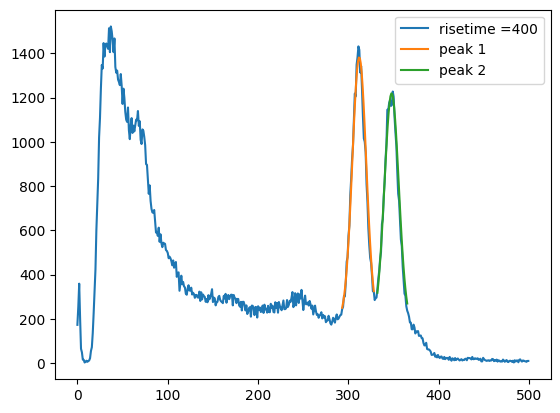

In [74]:
filelocation = r"C:\Users\Operator\Documents\Devin\Code\Data\NaI_Co60_120s.h5"
risetime = 400

spectra = CreateSpectra(filelocation, events, XRange, preTrgrDly, risetime)
hist, bins = np.histogram(spectra, bins = 500, range = (0, 200000))
plt.plot(range(np.size(hist)), hist, label="risetime =" + str(risetime))
Xranges, coefficients, numberofpeaks, FWHMs = PeakInfo(hist, peakdistance, prominencefactor)
for i in range(numberofpeaks):
    plt.plot(Xranges[i], Gaussian(Xranges[i], *coefficients[i]), label="peak " + str(i+1))
    print("Centroid is at: " + str(coefficients[i][1]))
    peak_locations.append(coefficients[i][1])
    print("FWHM is: " + str(2.35*coefficients[i][2]))
    print("% Resolution = " + str(100*2.35*coefficients[i][2]/coefficients[i][1]))
    peak_resolutions.append(100*2.35*coefficients[i][2]/coefficients[i][1])
plt.legend(loc='upper right')
plt.show()

Centroid is at: 16.25520128875879
FWHM is: 5.131718284509093
% Resolution = 31.569700020004728
Centroid is at: 40.66170242288693
FWHM is: 5.496979439424274
% Resolution = 13.518812818644387
Centroid is at: 76.00112716599999
FWHM is: 5.853865941056727
% Resolution = 7.7023409511688445
Centroid is at: 105.2940594182854
FWHM is: 11.060008013704524
% Resolution = 10.503924034088326
Centroid is at: 221.01585732410933
FWHM is: 15.766596593203598
% Resolution = 7.13369474213003
Centroid is at: 298.80998539221184
FWHM is: 18.443938585913806
% Resolution = 6.172463936138102
Centroid is at: 369.27776911302135
FWHM is: 21.866294175374804
% Resolution = 5.921367600301549


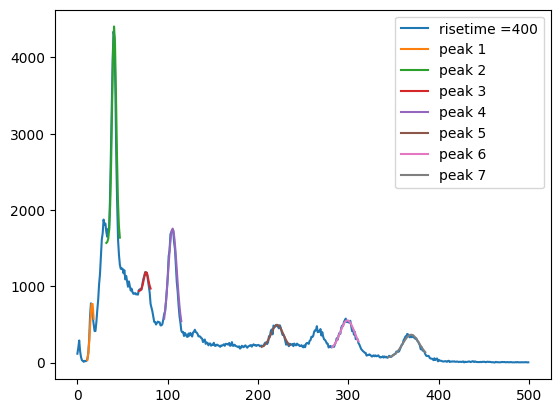

In [75]:
filelocation = r"C:\Users\Operator\Documents\Devin\Code\Data\NaI_Eu152_120s.h5"
prominencefactor = 15

spectra = CreateSpectra(filelocation, events, XRange, preTrgrDly, risetime)
hist, bins = np.histogram(spectra, bins = 500, range = (0,200000))
plt.plot(range(np.size(hist)), hist, label="risetime =" + str(risetime))
Xranges, coefficients, numberofpeaks, FWHMs = PeakInfo(hist, peakdistance, prominencefactor)
for i in range(numberofpeaks):
    plt.plot(Xranges[i], Gaussian(Xranges[i], *coefficients[i]), label="peak " + str(i+1))
    print("Centroid is at: " + str(coefficients[i][1]))
    peak_locations.append(coefficients[i][1])
    print("FWHM is: " + str(2.35*coefficients[i][2]))
    print("% Resolution = " + str(100*2.35*coefficients[i][2]/coefficients[i][1]))
    peak_resolutions.append(100*2.35*coefficients[i][2]/coefficients[i][1])
plt.legend(loc='upper right')
plt.show()

Centroid is at: 56.789046156346046
FWHM is: 298.3331168617182
% Resolution = 525.3356713200934
Centroid is at: 151.12280878778043
FWHM is: 13.187578924627687
% Resolution = 8.726398768267213
Centroid is at: 338.41449773698236
FWHM is: 19.72476474710913
% Resolution = 5.828581481884186


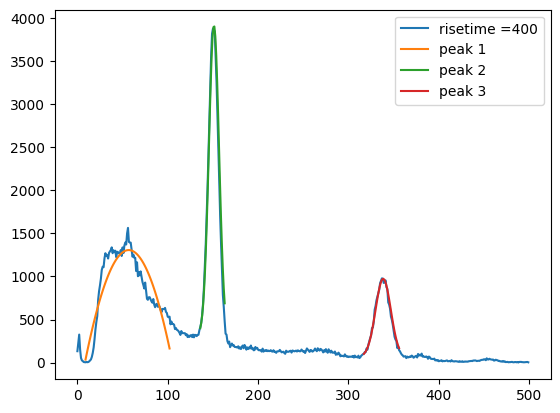

In [76]:
filelocation = r"C:\Users\Operator\Documents\Devin\Code\Data\NaI_Na22_120s.h5"

spectra = CreateSpectra(filelocation, events, XRange, preTrgrDly, risetime)
hist, bins = np.histogram(spectra, bins = 500, range = (0,200000))
plt.plot(range(np.size(hist)), hist, label="risetime =" + str(risetime))
Xranges, coefficients, numberofpeaks, FWHMs = PeakInfo(hist, peakdistance, prominencefactor)
for i in range(numberofpeaks):
    plt.plot(Xranges[i], Gaussian(Xranges[i], *coefficients[i]), label="peak " + str(i+1))
    print("Centroid is at: " + str(coefficients[i][1]))
    print("FWHM is: " + str(2.35*coefficients[i][2]))
    print("% Resolution = " + str(100*2.35*coefficients[i][2]/coefficients[i][1]))
plt.legend(loc='upper right')
plt.show()

Not going to use these

Centroid is at: 27.958044921540633
FWHM is: 4.9117499635187345
% Resolution = 17.568288402507047
Centroid is at: 48.26555151588677
FWHM is: 22.83121547478208
% Resolution = 47.30333489977237
Centroid is at: 92.16397183901076
FWHM is: 8.80596930941482
% Resolution = 9.554676446450053
Centroid is at: 108.2124924616173
FWHM is: 10.257067710057473
% Resolution = 9.478635485358247


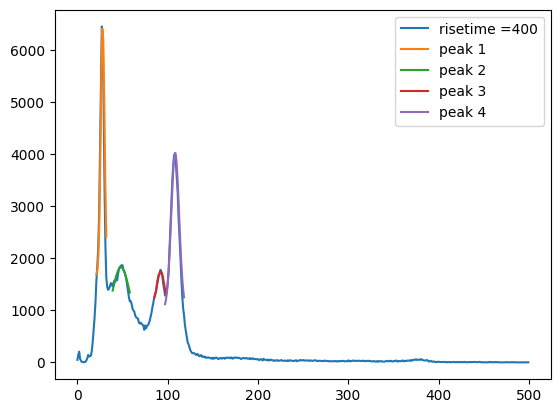

In [77]:
filelocation = r"C:\Users\Operator\Documents\Devin\Code\Data\NaI_Ba133_120s.h5"

spectra = CreateSpectra(filelocation, events, XRange, preTrgrDly, risetime)
hist, bins = np.histogram(spectra, bins = 500, range = (0,200000))
plt.plot(range(np.size(hist)), hist, label="risetime =" + str(risetime))
Xranges, coefficients, numberofpeaks, FWHMs = PeakInfo(hist, peakdistance, prominencefactor)
for i in range(numberofpeaks):
    plt.plot(Xranges[i], Gaussian(Xranges[i], *coefficients[i]), label="peak " + str(i+1))
    print("Centroid is at: " + str(coefficients[i][1]))
    peak_locations.append(coefficients[i][1])
    print("FWHM is: " + str(2.35*coefficients[i][2]))
    print("% Resolution = " + str(100*2.35*coefficients[i][2]/coefficients[i][1]))
    peak_resolutions.append(100*2.35*coefficients[i][2]/coefficients[i][1])
plt.legend(loc='upper right')
plt.show()

In [78]:
corresponding_energies = []